In [1]:
%run qsu.ipynb  # color-printing functions
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import INIDErrorModel
from qecsim.models.rotatedplanar import RotatedPlanarCode, RotatedPlanarMWPMDecoder


# set random seed for reproducibility
rng = np.random.default_rng(16)

# initialise models
rotated_planar_code = RotatedPlanarCode(7, 7)
my_code = rotated_planar_code

t = 1e-6
T_1 = rng.random(my_code.n_k_d[0])*1e-4
T_2 = []
for i in range(len(T_1)):
    T = rng.random()*1e-4
    while T > 2*T_1[i]:
        T = rng.random()*1e-4
    T_2.append(T)

my_error_model = INIDErrorModel(T_1, T_2)
my_decoder = RotatedPlanarMWPMDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)

# sample a random error
error = my_error_model.generate(rotated_planar_code, t=t, rng=rng)
qsu.print_pauli(rotated_planar_code.new_pauli(error))

RotatedPlanarCode(7, 7)
INIDErrorModel()
RotatedPlanarMWPMDecoder()


In [2]:
# get the syndrome corresponding to the sampled error. Syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, rotated_planar_code.stabilizers.T)
qsu.print_pauli('syndrome:\n{}'.format(my_code.ascii_art(syndrome)))

# get the plaquette indices for the syndrome and split into X and Z type plaquettes
x_syndrome, z_syndrome = [], []
for plaquette_index in rotated_planar_code.syndrome_to_plaquette_indices(syndrome):
    x_syndrome.append(plaquette_index) if rotated_planar_code.is_x_plaquette(plaquette_index) else z_syndrome.append(plaquette_index)

## Visualize the syndrome subgraphs and the result of MWPM

In [3]:
# the _create_subgraph method of the RotatedPlanarMWPMDecoder class creates the subgraph of the x and z plaquettes from the plaquette indices
# of the syndromes. gt.SimpleGraph is used to create the subgraphs.
x_subgraph = my_decoder._create_subgraph(rotated_planar_code, x_syndrome)
z_subgraph = my_decoder._create_subgraph(rotated_planar_code, z_syndrome)

Failed to load clib: libpypm.so.


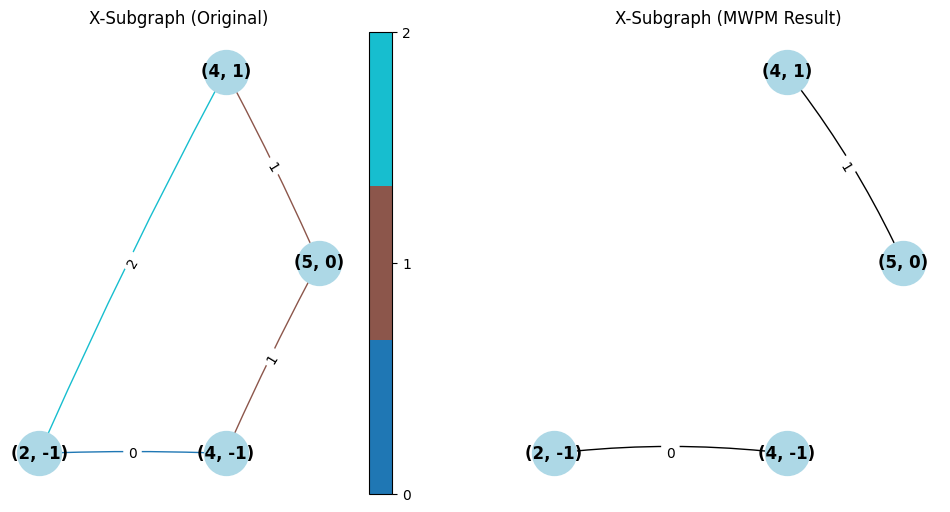

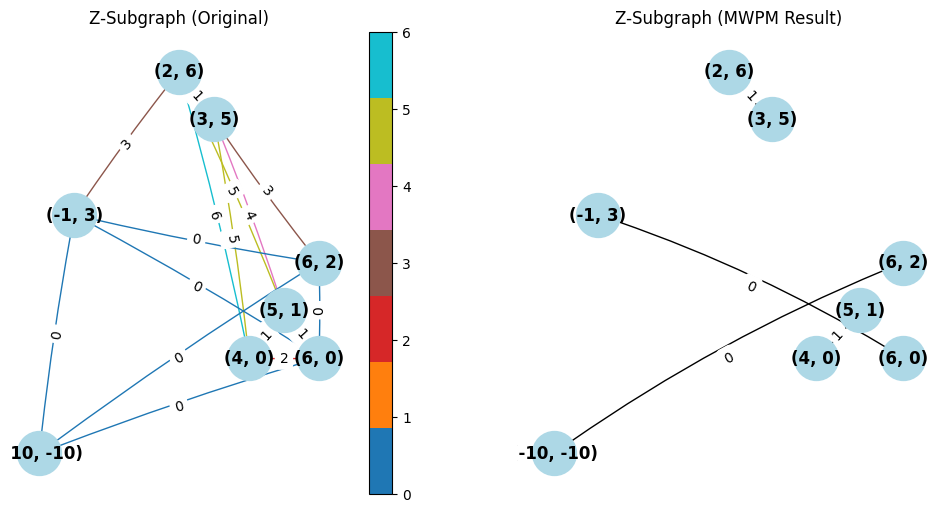

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from qecsim.graphtools import mwpm
import networkx as nx

titles = ['X-Subgraph', 'Z-Subgraph']

for g, graph in enumerate([x_subgraph, z_subgraph]):
        G = nx.Graph()
        G.add_weighted_edges_from((a,b, w) for (a,b), w in graph.items())

        # Create a figure and an Axes object
        fig, ax = plt.subplots(1,2, figsize=(12,6))

        # get the positions of the nodes
        positions = {v: v for v in G.nodes()}

        # change position of extra virtual nodes for plotting
        positions[(-9,-10)] = (-1, -2)
        positions[(-10,-10)] = (-2, -2)

        # Get the weights of the edges
        weights = nx.get_edge_attributes(G, 'weight').values()
        # Create a discrete colormap
        cmap = plt.get_cmap('tab10', max(weights) - min(weights) + 1)
        # Normalize the weights to the range [0, 1]
        norm = plt.Normalize(min(weights), max(weights))

        # Draw the graph with the nodes on the x and y coordinates of the syndrome plaquettes
        nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', font_weight='bold', node_size=1000, 
                connectionstyle='arc3, rad = 0.02', arrows=True, edge_color=weights, edge_cmap=cmap, ax=ax[0])

        nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=nx.get_edge_attributes(G, 'weight'), ax=ax[0])

        # Draw colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax[0], ticks=np.arange(min(weights), max(weights) + 1))


        mwpm_graph = mwpm(graph)
        G_mwpm = G.edge_subgraph(mwpm_graph)
        nx.draw(G_mwpm, pos=positions, with_labels=True, node_color='lightblue', font_weight='bold', node_size=1000,
                connectionstyle='arc3, rad = 0.06', arrows=True, ax=ax[1])
        nx.draw_networkx_edge_labels(G_mwpm, pos=positions, edge_labels=nx.get_edge_attributes(G_mwpm, 'weight'), ax=ax[1])
        
        ax[0].set_title(titles[g] + ' (Original)')
        ax[1].set_title(titles[g] + ' (MWPM Result)')
        plt.show()

## Decode the syndrome subgraphs

In [5]:
# Find the minimum weight perfect matching of each subgraph using the mwpm function of the graphtools module
mwpm_x_subgraph = mwpm(x_subgraph)
mwpm_z_subgraph = mwpm(z_subgraph)

extra_virtual_plaquettes = (my_decoder._extra_virtual_x_plaquette, my_decoder._extra_virtual_z_plaquette)
recovery_operator = rotated_planar_code.new_pauli().to_bsf()

for graph in [mwpm_x_subgraph, mwpm_z_subgraph]:
    for a_index, b_index in graph:
        # Ignore the extra virtual plaquettes, that are used in order to enable perfect matching in the case of odd number of nodes
        if (a_index in extra_virtual_plaquettes or b_index in extra_virtual_plaquettes):
            continue
        # Ignore the matching of two virtual plaquettes
        if rotated_planar_code.is_virtual_plaquette(a_index) and rotated_planar_code.is_virtual_plaquette(b_index):
            continue
        recovery_operator ^= my_decoder._path_operator(rotated_planar_code, a_index, b_index)

qsu.print_pauli('original error:\n{}'.format(rotated_planar_code.new_pauli(error)))
qsu.print_pauli("Recovery:\n{}".format(rotated_planar_code.new_pauli(recovery_operator)))

In [6]:
print(pt.bsp(recovery_operator ^ error, my_code.stabilizers.T))
qsu.print_pauli('recovery ^ error:\n{}'.format(my_code.new_pauli(recovery_operator ^ error)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
print(pt.bsp(recovery_operator ^ error, my_code.logicals.T))

[0 0]


## Plotting logical failure rate as a function of physical error rate for rotated planar stabilizer codes with MWPM decoding and i.ni.d. noise model

In [14]:
from qecsim import app

# set random seed for reproducibility
rng = np.random.default_rng(18)

codes = [RotatedPlanarCode(5, 5), RotatedPlanarCode(7, 7), RotatedPlanarCode(9, 9)]
times = np.logspace(-5.7, -4, 10)

# T_1 = rng.random(codes[-1].n_k_d[0])*1e-4
# T_2 = []
# for i in range(len(T_1)):
#     T = rng.random()*1e-4
#     while T > 2*T_1[i]:
#         T = rng.random()*1e-4
#     T_2.append(T)
 
# T_1 and T_2 data from ibm_sherbrooke 11.03.2024 
T_1 = [4.47131398e-04, 2.26458412e-04, 2.92798247e-04, 2.90948197e-04, 3.40581391e-04, 2.83836831e-04, 2.70656858e-04, 1.53601864e-04, 3.61852447e-04, 2.42139994e-04, 2.00143049e-04, 3.61774782e-04, 2.45283244e-04, 3.47100922e-04, 2.93481282e-04, 4.21930409e-04, 2.52775994e-04, 2.77442387e-04, 2.46129903e-04, 3.78459014e-04, 2.45232302e-04, 2.96744679e-04, 1.78567010e-04, 3.93160649e-04, 3.59094685e-04, 2.86956081e-04, 3.45384767e-04, 3.86961497e-04, 2.05691776e-04, 4.28754692e-04, 3.74780068e-04, 2.88966813e-04, 2.47889883e-04, 3.86880708e-04, 1.24536308e-04, 2.62453326e-04, 9.64438829e-05, 2.64377947e-04, 1.28466986e-04, 1.31691725e-04, 4.36206180e-04, 2.22960692e-04, 4.25424927e-04, 3.95216491e-04, 2.28763892e-04, 4.03873696e-04, 2.71036498e-04, 3.23739417e-04, 3.55001763e-04, 4.63425047e-05, 2.94978244e-04, 2.28271419e-04, 4.06929723e-04, 2.56146538e-04, 1.72188791e-04, 1.73462107e-04, 2.74696491e-04, 2.30326227e-04, 3.00553262e-04, 2.27812102e-04, 2.89711877e-04, 2.59015813e-04, 1.16374746e-04, 2.10523923e-04, 3.21825423e-04, 2.52531191e-04, 3.50659516e-04, 3.59079952e-04, 2.68641573e-04, 2.33773519e-04, 2.97749853e-04, 2.08399114e-04, 2.43029285e-04, 2.85902283e-04, 2.84630852e-04, 3.55945256e-04, 2.97832844e-04, 2.36402484e-04, 2.49531082e-04, 1.33130091e-04, 2.19092374e-04, 2.40286350e-04, 3.34206274e-04, 3.67597836e-04, 2.55269321e-04, 2.47502383e-04, 2.61491269e-04, 2.02710898e-04, 2.40839962e-04, 3.28335949e-04, 2.54947652e-04, 1.86721803e-04, 4.09207513e-04, 3.30273185e-04, 2.61297556e-04, 2.64197469e-04, 1.26940583e-04, 2.75063562e-04, 2.02244248e-04, 3.59510470e-04, 1.84129054e-04, 2.68350896e-04, 2.43577740e-04, 2.18748598e-04, 5.43395245e-05, 3.00174758e-04, 1.12444264e-04, 2.96240040e-04, 2.45289428e-04, 1.33545326e-04, 3.30455266e-04, 1.86542047e-04, 1.80401351e-04, 3.43144232e-04, 2.29711485e-04, 2.86391366e-04, 1.98113525e-04, 2.63177780e-04, 3.06908883e-04, 3.28242820e-04, 1.92885813e-04, 1.40990586e-04, 7.05505794e-05, 2.17445019e-04, 3.10653668e-04]    
T_2 = [2.63153399e-04, 2.86761491e-04, 1.41151669e-04, 1.66627797e-04, 1.89576638e-04, 2.92269093e-04, 2.25063209e-04, 1.81702907e-04, 2.61984119e-04, 6.11325611e-05, 1.51575773e-04, 7.41630478e-05, 2.20899934e-04, 1.02816518e-04, 5.27691939e-05, 1.76258452e-04, 7.50720939e-05, 7.53161361e-05, 5.95427485e-05, 4.67441780e-05, 6.18971486e-05, 2.34925562e-05, 2.04210901e-04, 2.20918687e-04, 1.13223403e-04, 4.50195613e-04, 2.14757890e-04, 1.48510585e-04, 7.82218006e-05, 1.92858061e-04, 2.79777668e-04, 3.21622414e-05, 1.26789703e-04, 2.57254131e-04, 1.03558923e-04, 5.48399307e-05, 4.24278864e-05, 3.44606876e-04, 6.01732031e-05, 6.37432976e-05, 2.06647237e-04, 3.28893299e-04, 3.36020790e-04, 2.55291187e-04, 2.83855122e-04, 3.11659323e-04, 3.16825279e-04, 1.20567129e-04, 3.31208982e-04, 7.45987011e-05, 1.50608995e-04, 7.74456392e-05, 2.81359658e-04, 5.08315903e-05, 2.03901246e-04, 1.69324501e-05, 6.82253376e-05, 1.20970691e-04, 2.80741944e-04, 2.62828664e-04, 2.86550495e-04, 2.31743470e-04, 8.82750115e-05, 1.96014297e-04, 2.98465911e-04, 6.06746939e-05, 2.26737507e-04, 6.31369444e-05, 1.86726857e-05, 2.47944963e-04, 1.26382882e-04, 2.54025918e-04, 1.78993791e-04, 1.91150516e-04, 1.79769739e-04, 8.40042940e-05, 1.70200659e-04, 3.51177500e-04, 2.96748335e-05, 1.39399172e-04, 1.90544238e-04, 2.02677259e-04, 4.09724041e-05, 3.11031137e-04, 1.01932181e-04, 1.07444847e-04, 3.08357110e-04, 1.29828189e-04, 5.47172067e-05, 2.86959303e-04, 1.45406519e-04, 1.04390303e-04, 2.40856220e-05, 2.90835503e-04, 1.36119607e-04, 1.35983968e-04, 1.85294934e-04, 2.28204312e-04, 5.14639823e-05, 3.78015232e-04, 7.73972055e-05, 1.87827250e-04, 2.29362850e-04, 2.91204961e-04, 4.20846188e-05, 1.85991695e-04, 1.24689673e-04, 2.96066649e-04, 1.72330249e-04, 2.51645808e-04, 4.66399761e-05, 6.16320063e-05, 2.21848271e-04, 2.79667140e-04, 3.75513828e-04, 2.10413362e-04, 2.57497350e-04, 2.07386123e-04, 3.13663945e-04, 3.62394113e-05, 3.18518580e-04, 1.79348759e-04, 1.40142464e-04, 2.65291418e-05, 8.90078292e-05]

error_models = [INIDErrorModel(T_1[0:code.n_k_d[0]], T_2[0:code.n_k_d[0]]) for code in codes]

data = [app.run(code, error_models[c], my_decoder, t, max_runs=50000)
        for c, code in enumerate(codes) for t in times]
print(data[len(data)//2])

{'code': 'Rotated planar 7x7', 'n_k_d': (49, 1, 7), 'time_steps': 1, 'error_model': 'i.ni.d. error model', 'decoder': 'Rotated Planar MWPM', 'error_probability': 1.7556762912750012e-05, 'measurement_error_probability': 0.0, 'n_run': 50000, 'n_success': 47633, 'n_fail': 2367, 'n_logical_commutations': (2199, 191), 'custom_totals': None, 'error_weight_total': 216866, 'error_weight_pvar': 3.8078552176, 'logical_failure_rate': 0.04734, 'physical_error_rate': 0.08851673469387755, 'wall_time': 111.74943050008733}


In [15]:
# prepare code to x,y map and print
code_to_xys = {}
for run in data:
    xys = code_to_xys.setdefault(run['code'], [])
    xys.append((run['physical_error_rate'], run['logical_failure_rate']))
print('\n'.join('{}: {}'.format(k, v) for k, v in code_to_xys.items()))

Rotated planar 5x5: [(0.0120128, 0.00014), (0.0185592, 0.00088), (0.028137600000000002, 0.00272), (0.0423872, 0.008), (0.063812, 0.0246), (0.0945984, 0.06808), (0.1376088, 0.15764), (0.1952656, 0.29564), (0.267196, 0.4522), (0.3537904, 0.5933)]
Rotated planar 7x7: [(0.011048571428571428, 0.0), (0.017015102040816327, 0.00012), (0.02607469387755102, 0.00052), (0.03964816326530612, 0.00266), (0.059287346938775506, 0.01318), (0.08851673469387755, 0.04734), (0.12892857142857142, 0.13878), (0.18389102040816327, 0.3074), (0.25336367346938776, 0.49684), (0.33668, 0.64194)]
Rotated planar 9x9: [(0.012070123456790122, 0.0), (0.018554320987654322, 4e-05), (0.028042222222222222, 0.00026), (0.04233555555555556, 0.002), (0.06352691358024691, 0.01146), (0.0936995061728395, 0.05436), (0.13522444444444445, 0.16892), (0.19082518518518518, 0.3674), (0.2605493827160494, 0.55326), (0.34427407407407407, 0.67988)]


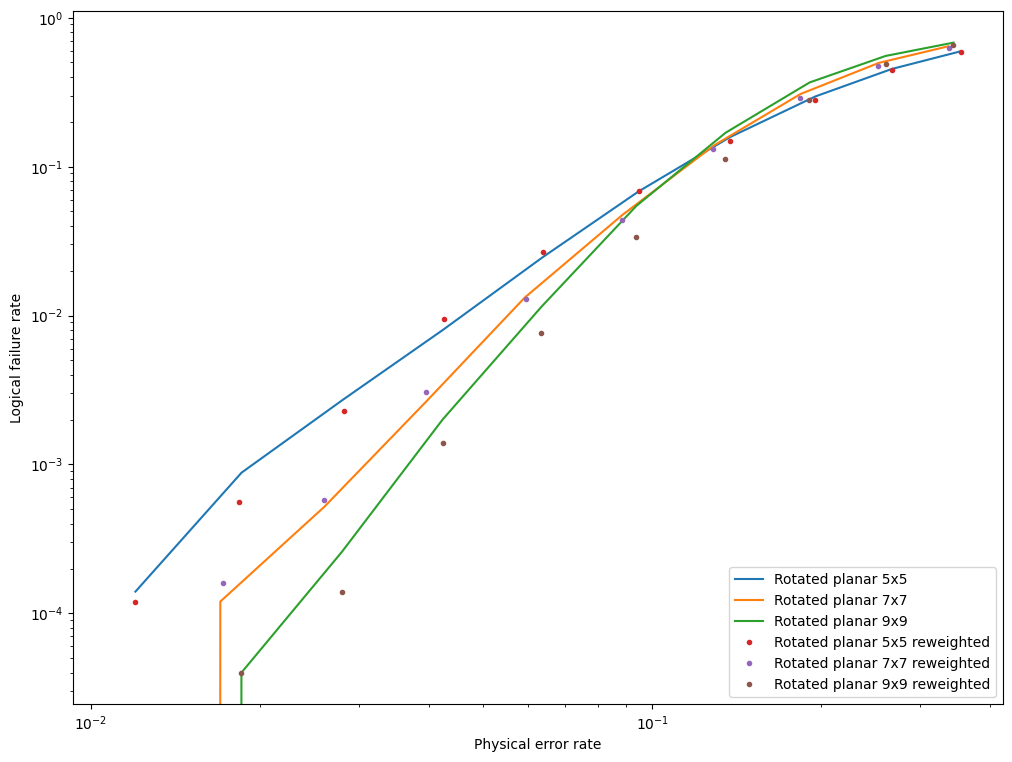

In [10]:
import matplotlib.pyplot as plt
# format plot
fig = plt.figure(1, figsize=(12, 9))
# plt.title('Rotated planar code simulation\n({} error model, {} decoder)'.format(my_error_model.label, my_decoder.label))
plt.xlabel('Physical error rate')
plt.ylabel('Logical failure rate')
# plt.xlim(3.3e-2, 2.5e-1)
# plt.ylim(1e-9, 0.65)
# add data

code_to_xys = {"Rotated planar 5x5": [(0.0120128, 0.00014), (0.0185592, 0.00088), (0.028137600000000002, 0.00272), (0.0423872, 0.008), (0.063812, 0.0246), (0.0945984, 0.06808), (0.1376088, 0.15764), (0.1952656, 0.29564), (0.267196, 0.4522), (0.3537904, 0.5933)],
                "Rotated planar 7x7": [(0.011048571428571428, 0.0), (0.017015102040816327, 0.00012), (0.02607469387755102, 0.00052), (0.03964816326530612, 0.00266), (0.059287346938775506, 0.01318), (0.08851673469387755, 0.04734), (0.12892857142857142, 0.13878), (0.18389102040816327, 0.3074), (0.25336367346938776, 0.49684), (0.33668, 0.64194)],
                "Rotated planar 9x9": [(0.012070123456790122, 0.0), (0.018554320987654322, 4e-05), (0.028042222222222222, 0.00026), (0.04233555555555556, 0.002), (0.06352691358024691, 0.01146), (0.0936995061728395, 0.05436), (0.13522444444444445, 0.16892), (0.19082518518518518, 0.3674), (0.2605493827160494, 0.55326), (0.34427407407407407, 0.67988)]
                }
for code, xys in code_to_xys.items():
    plt.plot(*zip(*xys), '-', label='{}'.format(code))
    
    
code_to_xys_2 = {'Rotated planar 5x5 reweighted': [(0.0120072, 0.00012), (0.0183968, 0.00056), (0.0282192, 0.0023), (0.042593599999999995, 0.00954), (0.0640144, 0.02662), (0.0946032, 0.06888), (0.1374008, 0.1493), (0.19471439999999998, 0.28104), (0.2674512, 0.44332), (0.354292, 0.58728)],
                 'Rotated planar 7x7 reweighted': [(0.011098775510204082, 0.0), (0.017199183673469388, 0.00016), (0.02607795918367347, 0.00058), (0.0395269387755102, 0.00306), (0.05966693877551021, 0.01288), (0.08820530612244898, 0.044), (0.12862897959183675, 0.13078), (0.1835134693877551, 0.2868), (0.25298530612244896, 0.47108), (0.337294693877551, 0.62654)],
                 'Rotated planar 9x9 reweighted': [(0.012081975308641975, 0.0), (0.018492345679012347, 4e-05), (0.028049135802469136, 0.00014), (0.042441728395061724, 0.0014), (0.06334938271604938, 0.00768), (0.09370148148148148, 0.03366), (0.13511925925925924, 0.11238), (0.19051876543209878, 0.27802), (0.2606195061728395, 0.48572), (0.34381432098765435, 0.65084)]}


for code, xys in code_to_xys_2.items():
    plt.plot(*zip(*xys), '.', label='{}'.format(code))
  
plt.legend(loc='lower right')
# plt.xlim(8e-2, 3e-1)
# plt.ylim(5e-2, 9e-1)
plt.loglog()
plt.show()